## Replication of Liu and Pan (2003)

Lea Lund Jeppesen (snk956) and Isabel Vega Andersen (csl804)

In [1]:
#This cell is for importing relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

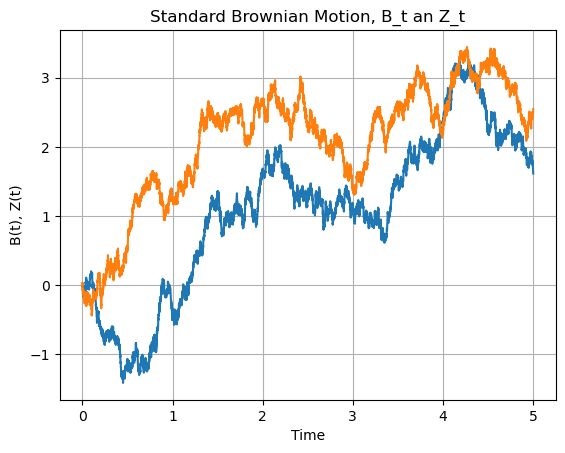

In [2]:
#We create a standard Brownian motion for Z_t and B_t

# Parameters
T_b = 5  # Total time
time_steps_b = 10000  # Number of steps
dt_b = T_b/time_steps_b  # Time step
t_b = np.linspace(0, T_b, time_steps_b+1)

# Standard Brownian motion for B_t
dBt = np.zeros(time_steps_b+1)
for i in range(1, time_steps_b+1):
    dBt[i] = dBt[i-1] + np.sqrt(dt_b) * np.random.normal()

# Standard Brownian motion for Z_t
dZt = np.zeros(time_steps_b+1)
for i in range(1, time_steps_b+1):
    dZt[i] = dZt[i-1] + np.sqrt(dt_b) * np.random.normal()

# Plotting the Brownian motion
plt.plot(t_b, dBt)
plt.plot(t_b, dZt)
plt.xlabel('Time')
plt.ylabel('B(t), Z(t)')
plt.title('Standard Brownian Motion, B_t an Z_t')
plt.grid(True)
plt.show()

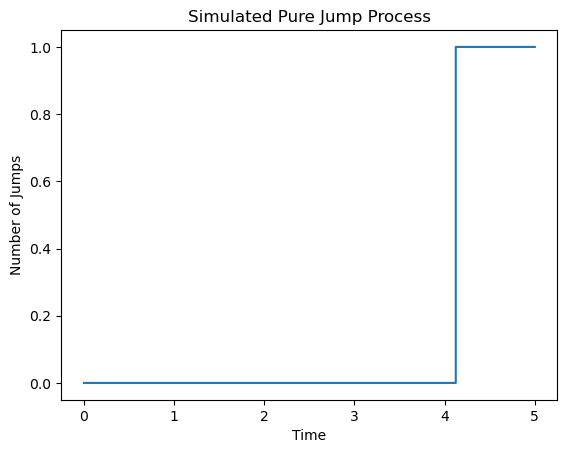

In [3]:
#We create a pure jump process N_t

# Parameters
T_j = 5  # Total time
lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)
time_steps_j = 10000 # Number of time steps
dt_j = T_j / time_steps_j  # Time step size

# Initialize the jump process
dNt = np.zeros(time_steps_j + 1)
jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

# Ensure the jump times do not exceed the total time
jump_times = jump_times[jump_times <= T_j]

# Plot the jump process
for t in range(1, time_steps_j + 1):
    dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt_j) & (jump_times < t * dt_j))

plt.step(np.linspace(0, T_j, time_steps_j + 1), dNt, where='post')
plt.xlabel('Time')
plt.ylabel('Number of Jumps')
plt.title('Simulated Pure Jump Process')
plt.show()

In [4]:
# Parameters for the main model

r=0.05 #risk free rate #Liu and Pan
eta= 4 #risk premium of diffusive risk #Liu and Pan
mu= -0.25 #stock price jumps, constant multiple >-1 (in pct.) #Liu and Pan
lambda_n = 0.2 #jump amplitude, >0 (see code above for jump process) #Derived from Liu and Pan 
lambda_q = 0.4 #risk premium for jump risk #3.5% per year estimated in Pan 2002
kappa= 5 #speed of mean reversion for V_t, >0 #Liu and Pan
nu_bar= 0.13**2 #long run volatility, >0 #Liu and Pan
sigma= 0.25 #volatility coefficient, >=0  #Liu and Pan (måske for højt?)
rho=-0.4 #correlation between diffusive and volatility shocks, 1>rho>-1 #Liu and Pan

#we imply the Feller condition
if 2*kappa*nu_bar>=sigma**2: 
    print('Feller True')
else: 
    print('Feller False')


Feller True


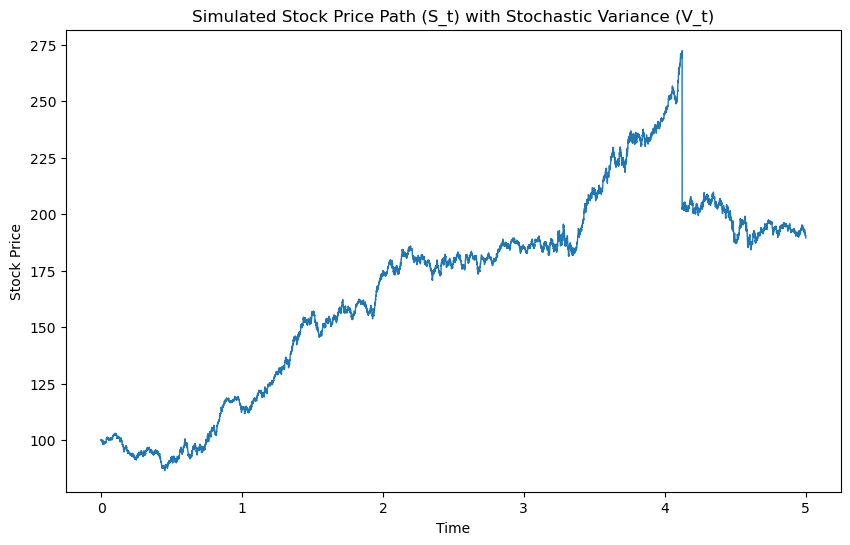

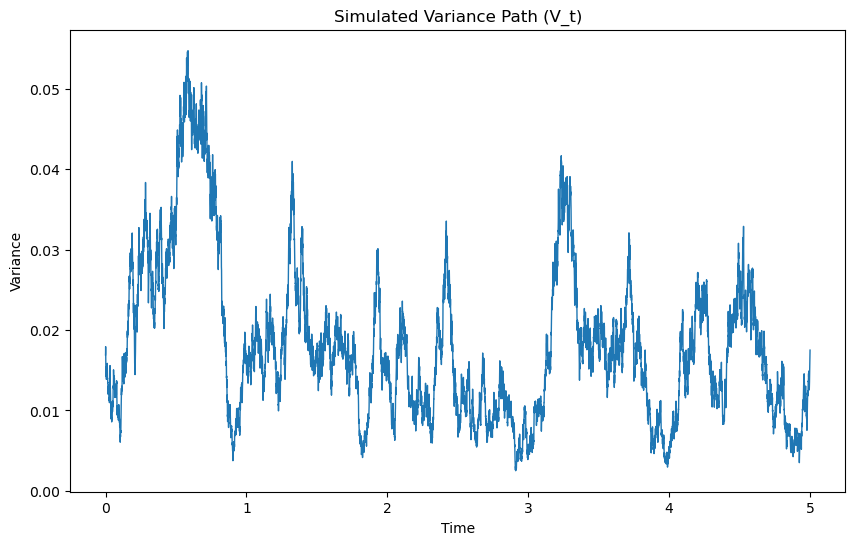

In [5]:
# Initial conditions
S0 = 100  # Initial stock price
V0 = nu_bar  # Initial variance
T = 5  # Total time
dt = 0.0005 # Time step
n_steps = int(T / dt)  # Number of time steps

# Initialize arrays for the simulation
S_paths = np.zeros(n_steps)
V_paths = np.zeros(n_steps)
S_paths[0] = S0
V_paths[0] = V0

for t in range(1, n_steps):
    # Volatility process (V_t)
    V_paths[t] = V_paths[t-1] + kappa * (nu_bar - V_paths[t-1]) * dt + sigma * np.sqrt(V_paths[t-1]) * (rho * (dBt[t]-dBt[t-1]) + np.sqrt(1 - rho**2) * (dZt[t]-dZt[t-1])) \
    
    if V_paths[t]<0: 
        V_paths[t]=abs(V_paths[t])

    # Stock price process (S_t)
    S_paths[t] = S_paths[t-1] +(r + eta * V_paths[t-1] + mu * (lambda_n - lambda_q) * V_paths[t-1]) * S_paths[t-1]*dt + \
                                 np.sqrt(V_paths[t-1])* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V_paths[t-1] * dt) \


# Plot the simulated stock price path
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), S_paths, lw=1)
plt.title('Simulated Stock Price Path (S_t) with Stochastic Variance (V_t)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Plot the simulated volatility path
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), V_paths, lw=1)
plt.title('Simulated Variance Path (V_t)')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.show()


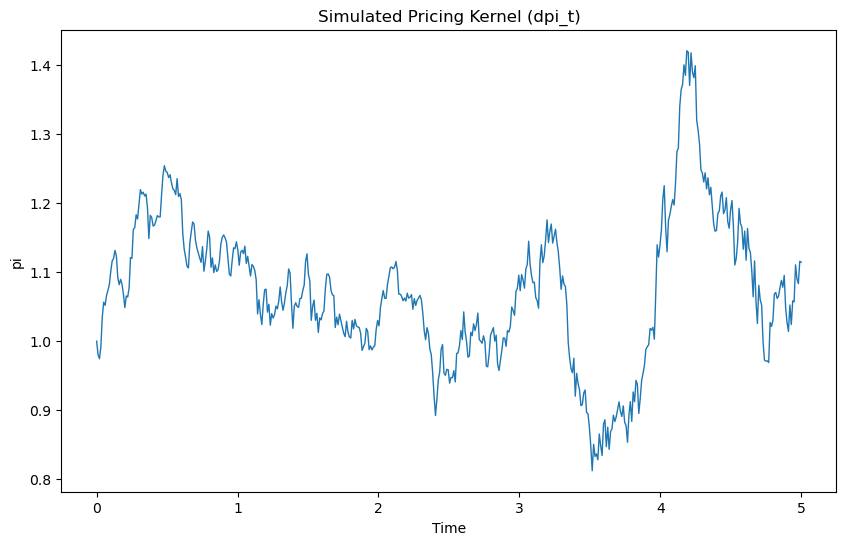

In [6]:
#We set up the pricing process for the derivative

# Parameters 
xi= -6 # The volatility risk premium #Liu and Pan

# Initial conditions
pi_0 = 1  # Parametric pricing kernel #Liu and Pan
T = 5  # Total time
dt = 0.01  # Time step
n_steps = int(T / dt)  # Number of time steps

# Initialize arrays for the simulation
pi_paths = np.zeros(n_steps)
pi_paths[0] = pi_0

for t in range(1, n_steps):
    pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V_paths[t-1])*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V_paths[t-1])*(dZt[t]-dZt[t-1]))+(lambda_q/lambda_n-1)*pi_paths[t-1]*((dNt[t]-dNt[t-1])-lambda_n*V_paths[t-1]*dt)

# Plot the simulated pi paths
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), pi_paths, lw=1)
plt.title('Simulated Pricing Kernel (dpi_t)')
plt.xlabel('Time')
plt.ylabel('pi')
plt.show()

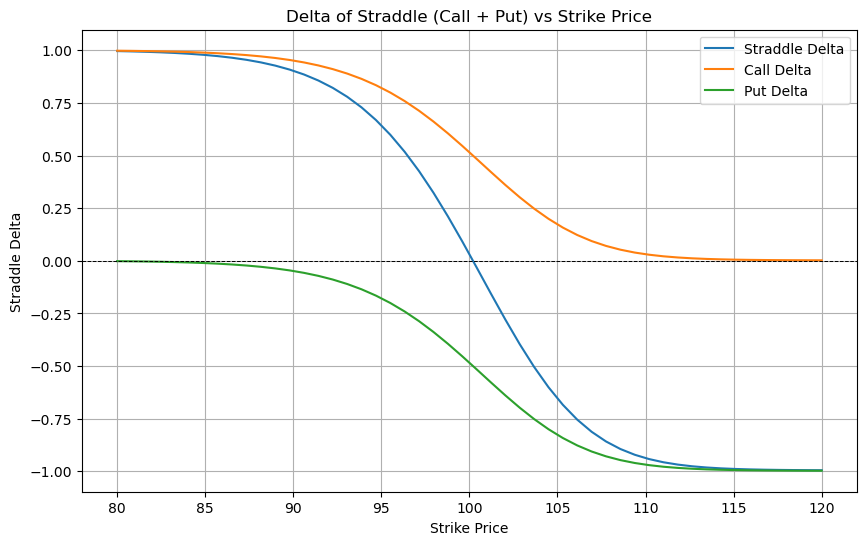

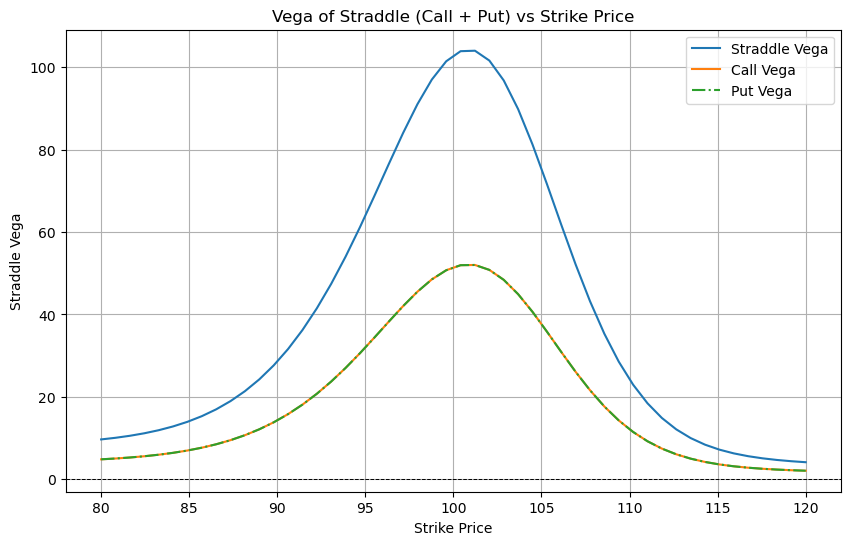

In [7]:
#To determine sensitivities, we have to set up pricing for the call and the put respectively

# Define functions for A(y) and B(y) as in the appendix
def B(y, a, q, b, t):
    term1 = (a * (1 - np.exp(-q * t))) / (2 * q - (q + b) * (1 - np.exp(-q * t)))
    return -term1

def A(y, kappa_star, v_bar_star, sigma, q, b, tau):
    term1 = kappa_star * v_bar_star / sigma**2
    term2 = (q+b)*tau + 2*np.log(1 - (q + b) / (2 * q) * (1 - np.exp(-q*tau))) 
    return -term1 * term2

# Characteristic function integrands for P1 and P2
def P1_integrand(u, S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu):
    y = 1 - 1j * u

    a = y*(1-y)-2*lambda_q*(np.exp(y)*(1+mu)-1-y*mu)
    b = sigma * rho * y - kappa_star
    q = np.sqrt(b**2 + a*sigma**2)
    
    B_val = B(y, a, q, b, T-tau)
    A_val = A(y, kappa_star, v_bar_star, sigma, q, b, tau)
    exponent = A_val + B_val * V + 1j * u * (np.log(K/S) + r * tau)
    return np.imag(np.exp(exponent)) / u

def P2_integrand(u, S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu):
    y = -1j * u

    a = y*(1-y)-2*lambda_q*(np.exp(y)*(1+mu)-1-y*mu)
    b = sigma * rho * y - kappa_star
    q = np.sqrt(b**2 + a*sigma**2)

    B_val = B(y, a, q, b, T-tau)
    A_val = A(y, kappa_star, v_bar_star, sigma, q, b, tau)
    exponent = A_val + B_val * V + 1j * u * (np.log(K/S) + r * tau)
    return np.imag(np.exp(exponent)) / u

# Compute P1 and P2
def compute_P1_P2(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu):
    P1 = 0.5 - (1 / np.pi) * quad(P1_integrand, 0, 10000, args=(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu))[0]
    P2 = 0.5 - (1 / np.pi) * quad(P2_integrand, 0, 10000, args=(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu))[0]
    return P1, P2

# European option pricing and delta calculation
def european_option_price_and_delta(S, K, V, r, tau, option_type="call"):
    P1, P2 = compute_P1_P2(S, K, V, r, tau, sigma, rho, kappa_star, lambda_q, mu)
    if option_type == "call":
        price = S * P1 - np.exp(-r * tau) * K * P2
        delta = P1
    elif option_type == "put":
        price = np.exp(-r * tau) * K * (1 - P2) - S * (1 - P1)
        delta = P1-1
    return price, delta

# Calculate delta-neutral straddle
def calculate_straddle_delta(S, K, V, r, tau):
    _, delta_call = european_option_price_and_delta(S, K, V, r, tau, option_type="call")
    _, delta_put = european_option_price_and_delta(S, K, V, r, tau, option_type="put")
    straddle_delta = delta_call + delta_put
    return straddle_delta

# Vega for European option (partial derivative w.r.t. volatility)
def european_option_vega(S, K, V, r, tau, option_type="call"):
    epsilon = 1e-5  # Small change in V for numerical differentiation

    P1_high, P2_high = compute_P1_P2(S, K, V + epsilon, r, tau, sigma, rho, kappa_star, lambda_q, mu)
    P1_low, P2_low = compute_P1_P2(S, K, V - epsilon, r, tau, sigma, rho, kappa_star, lambda_q, mu)
    
    if option_type == "call":
        price_high = S * P1_high - np.exp(-r * tau) * K * P2_high
        price_low = S * P1_low - np.exp(-r * tau) * K * P2_low
    elif option_type == "put":
        price_high = np.exp(-r * tau) * K * (1 - P2_high) - S * (1 - P1_high)
        price_low = np.exp(-r * tau) * K * (1 - P2_low) - S * (1 - P1_low)
    
    # Calculate vega using central difference approximation
    vega = (price_high -price_low) / (2 * epsilon)
    return vega

# Calculate vega-neutral straddle
def calculate_straddle_vega(S, K, V, r, tau):
    vega_call = european_option_vega(S, K, V, r, tau, option_type="call")
    vega_put = european_option_vega(S, K, V, r, tau, option_type="put")
    straddle_vega = vega_call + vega_put
    return straddle_vega

# Parameters for Liu and Pan model
S = 100         # Stock price
K = 100         # Strike price
V = 0.15**2        # Variance
tau = 0.1         # Time to maturity (in years)

# Additional terms for B and A as per Liu and Pan
kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
v_bar_star = kappa * nu_bar / kappa_star

# Calculate and plot straddle delta across different strikes around ATM
strike_prices = np.linspace(80, 120, 50)
straddle_deltas = [calculate_straddle_delta(S, K, V, r, tau) for K in strike_prices]

put_deltas=[]
call_deltas=[]
for K in strike_prices:
    _, delta_put = european_option_price_and_delta(S, K, V, r, tau, option_type="put")
    put_deltas.append(delta_put)
    _, delta_call = european_option_price_and_delta(S, K, V, r, tau, option_type="call")
    call_deltas.append(delta_call)

# Calculate and plot straddle vega across different strikes around ATM
strike_prices = np.linspace(80, 120, 50)
straddle_vegas = [calculate_straddle_vega(S, K, V, r, tau) for K in strike_prices]
call_vegas=[european_option_vega(S, K, V, r, tau, option_type="call") for K in strike_prices]
put_vegas=[european_option_vega(S, K, V, r, tau, option_type="put") for K in strike_prices]

# Plotting the delta of the straddle
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, straddle_deltas, label="Straddle Delta")
plt.plot(strike_prices, call_deltas, label="Call Delta")
plt.plot(strike_prices, put_deltas, label="Put Delta")
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel("Strike Price")
plt.ylabel("Straddle Delta")
plt.title("Delta of Straddle (Call + Put) vs Strike Price")
plt.legend()
plt.grid()
plt.show()

# Plotting the vega of the straddle
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, straddle_vegas, label="Straddle Vega")
plt.plot(strike_prices, call_vegas, label="Call Vega")
plt.plot(strike_prices, put_vegas, linestyle='-.', label="Put Vega")
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel("Strike Price")
plt.ylabel("Straddle Vega")
plt.title("Vega of Straddle (Call + Put) vs Strike Price")
plt.legend()
plt.grid()
plt.show()


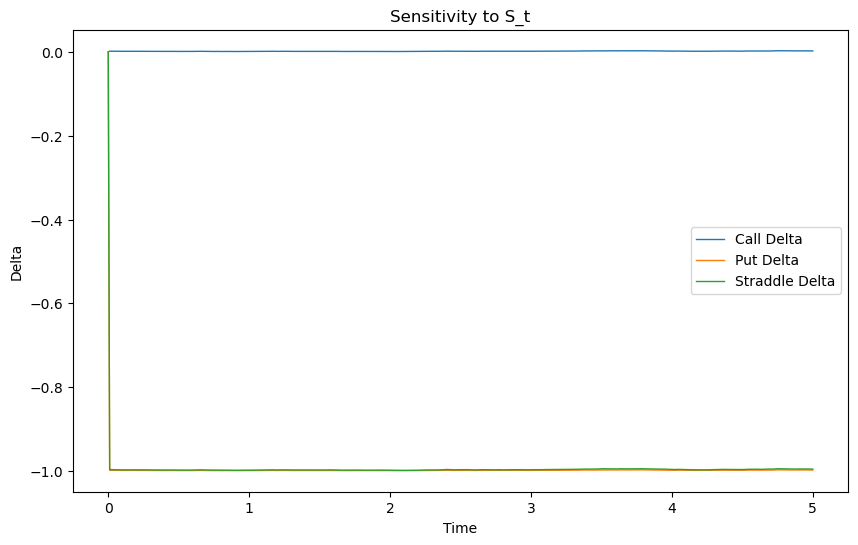

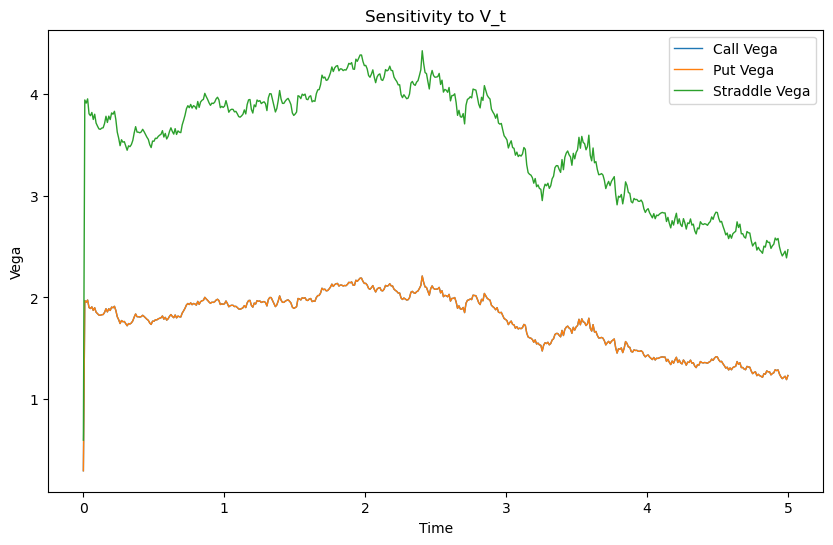

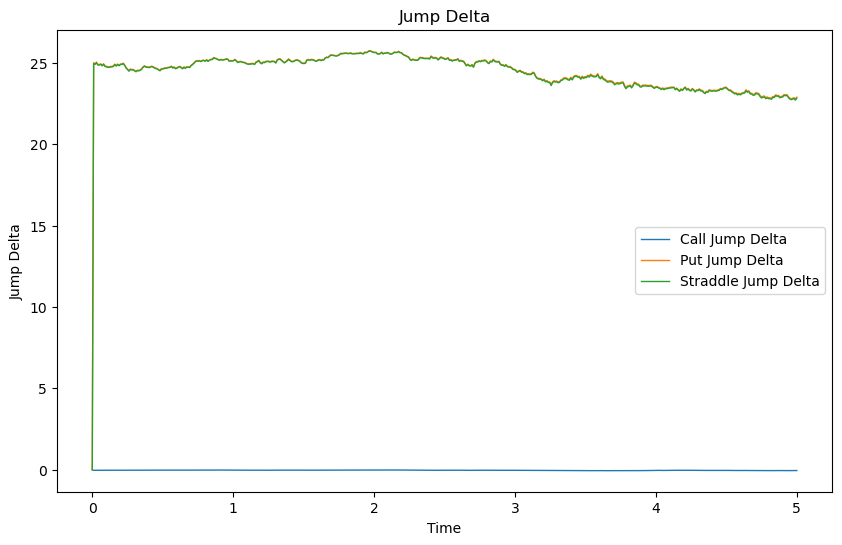

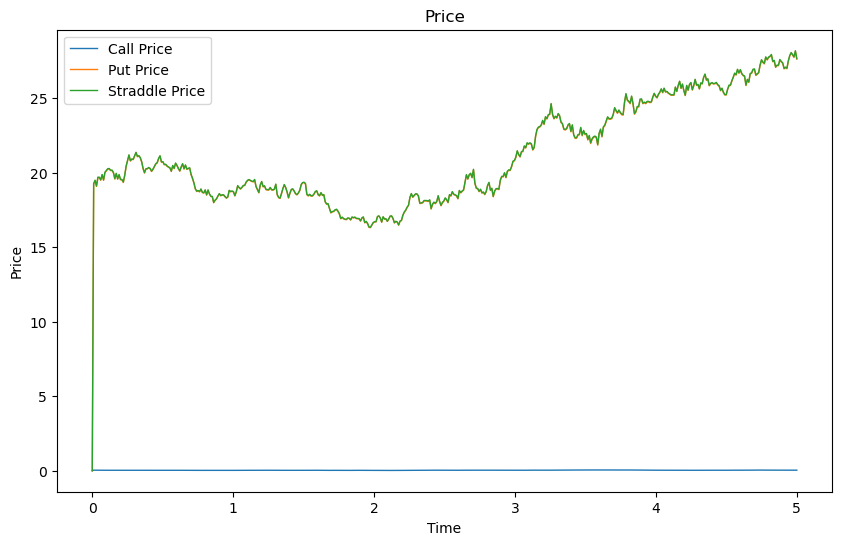

In [8]:
#We create a loop that calculates delta and vega for the straddle for different prices $S_t$

# Initialize sensitivities
g_s_1 = np.zeros(n_steps)
g_v_1 = np.zeros(n_steps)
price_1=np.zeros(n_steps)
price_jump_1=np.zeros(n_steps)
delta_g_1 = np.zeros(n_steps)

g_s_2 = np.zeros(n_steps)
g_v_2 = np.zeros(n_steps)
price_2=np.zeros(n_steps)
price_jump_2=np.zeros(n_steps)
delta_g_2 = np.zeros(n_steps)

g_s_1[0] = 0
g_v_1[0] = 0.3
g_s_2[0] = 0
g_v_2[0] = 0.3
delta_g_1[0] = 0
delta_g_2[0] = 0

for t in range(1, n_steps):
    # Calculate delta and vega for the call and put using finite differences
    price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], K, V_paths[t], r, tau, option_type="call")
    g_v_1[t] = european_option_vega(S_paths[t], K, V_paths[t], r, tau, option_type="call")
    price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], K, V_paths[t], r, tau, option_type="put")
    g_v_2[t] = european_option_vega(S_paths[t], K, V_paths[t], r, tau, option_type="put")

    price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), K, V_paths[t], r, tau, option_type="call")
    price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), K, V_paths[t], r, tau, option_type="put")

    # Calculate jump deltas for call and put
    delta_g_1[t] = price_jump_1[t]-price_1[t]
    delta_g_2[t] = price_jump_2[t]-price_2[t]

# Plot the simulated paths
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), g_s_1, lw=1, label="Call Delta")
plt.plot(np.linspace(0, T, n_steps), g_s_2, lw=1, label="Put Delta")
plt.plot(np.linspace(0, T, n_steps), g_s_1+g_s_2, lw=1, label="Straddle Delta")
plt.title('Sensitivity to S_t')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), g_v_1, lw=1, label="Call Vega")
plt.plot(np.linspace(0, T, n_steps), g_v_2, lw=1, label="Put Vega")
plt.plot(np.linspace(0, T, n_steps), g_v_1+g_v_2, lw=1, label="Straddle Vega")
plt.title('Sensitivity to V_t')
plt.xlabel('Time')
plt.ylabel('Vega')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), delta_g_1, lw=1, label="Call Jump Delta")
plt.plot(np.linspace(0, T, n_steps), delta_g_2, lw=1, label="Put Jump Delta")
plt.plot(np.linspace(0, T, n_steps), delta_g_1+delta_g_2, lw=1, label="Straddle Jump Delta")
plt.title('Jump Delta')
plt.xlabel('Time')
plt.ylabel('Jump Delta')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), price_1, lw=1, label="Call Price")
plt.plot(np.linspace(0, T, n_steps), price_2, lw=1, label="Put Price")
plt.plot(np.linspace(0, T, n_steps), price_1+price_2, lw=1, label="Straddle Price")
plt.title('Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

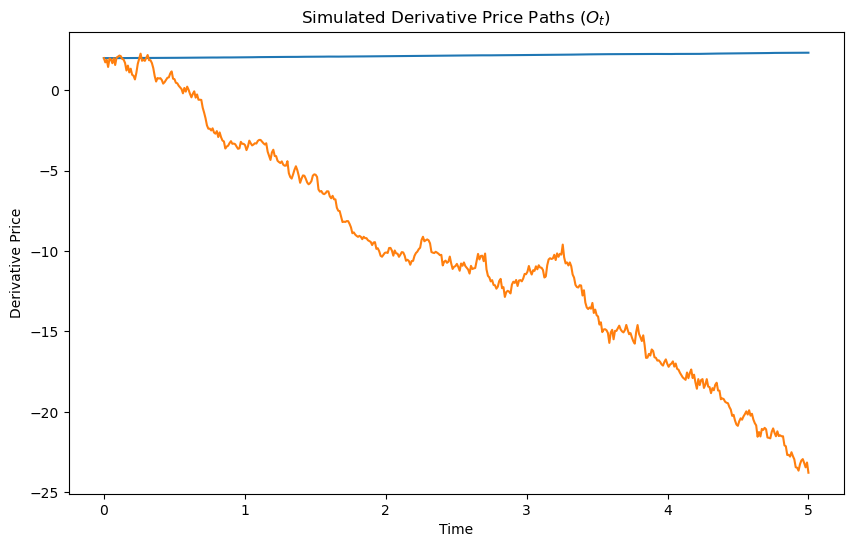

In [9]:
# Initial values
O0 = 2  # Initial derivative price

# Initialize the derivative price process O_t
O_path_1 = np.zeros((n_steps))
O_path_1[0] = O0  # Set initial derivative price
O_path_2 = np.zeros((n_steps))
O_path_2[0] = O0  # Set initial derivative price


# Simulate the derivative price O_t using Euler-Maruyama
for t in range(1, n_steps):
    
    # Calculate the jump term for the derivative
    #delta_g_i = delta_g(S_paths[t-1], V_paths[t-1], mu) 
    
    # Euler-Maruyama step for O_t

    O_path_1[t] = O_path_1[t-1] + r * O_path_1[t-1] * dt + \
                    (g_s_1[t] * S_paths[t-1] + sigma * rho * g_v_1[t]) * (eta * V_paths[t-1] * dt + np.sqrt(V_paths[t-1]) * (dBt[t]-dBt[t-1])) + \
                    sigma * np.sqrt(1 - rho**2) * g_v_1[t] * (xi * V_paths[t-1] * dt + np.sqrt(V_paths[t-1]) * (dZt[t]-dZt[t-1])) + \
                    delta_g_1[t] * ((lambda_n - lambda_q) * V_paths[t-1] * dt + (dNt[t]-dNt[t-1]) - lambda_n * V_paths[t-1] * dt)
    
    O_path_2[t] = O_path_2[t-1] + r * O_path_2[t-1] * dt + \
                    (g_s_2[t] * S_paths[t-1] + sigma * rho * g_v_2[t]) * (eta * V_paths[t-1] * dt + np.sqrt(V_paths[t-1]) * (dBt[t]-dBt[t-1])) + \
                    sigma * np.sqrt(1 - rho**2) * g_v_2[t] * (xi * V_paths[t-1] * dt + np.sqrt(V_paths[t-1]) * (dZt[t]-dZt[t-1])) + \
                    delta_g_2[t] * ((lambda_n - lambda_q) * V_paths[t-1] * dt + (dNt[t]-dNt[t-1]) - lambda_n * V_paths[t-1] * dt)

# Plot some of the simulated derivative price paths
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), O_path_1, label="Call")
plt.plot(np.linspace(0, T, n_steps), O_path_2, label="Put")
plt.title('Simulated Derivative Price Paths ($O_t$)')
plt.xlabel('Time')
plt.ylabel('Derivative Price')
plt.show()


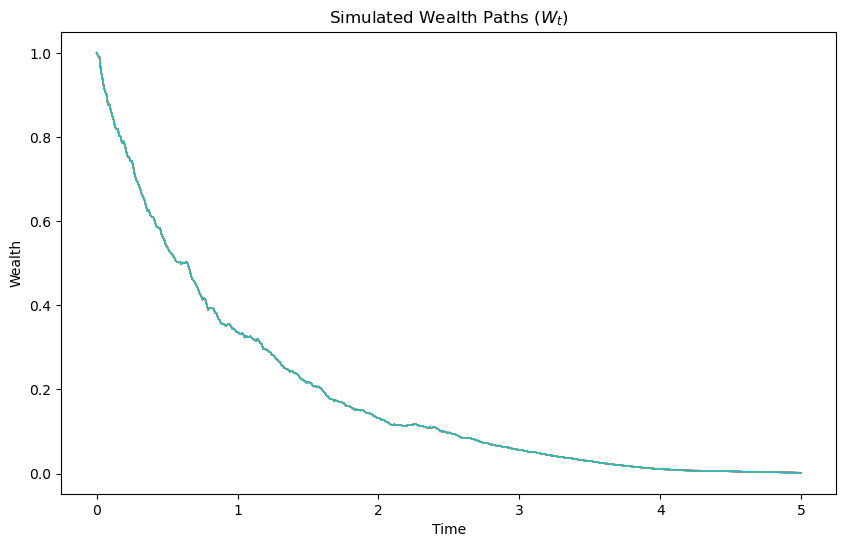

In [10]:
# We continue by defining the path for the wealth process 

# Initial wealth and asset values
W0 = 1.0  # Initial wealth
 
# Initialize the wealth process
W_paths = np.zeros((n_steps))
W_paths[0] = W0
 
# Initialize portfolio fractions
phi_t = 0.5  # Fraction of wealth in stock
psi_t_1 = 0.25  # Fraction of wealth in first derivative
psi_t_2 = 1-phi_t-psi_t_1  # Fraction of wealth in second derivative

# Simulate the wealth process using Euler-Maruyama
for t in range(1, n_steps):
    # Portfolio weights
    theta_B_t = phi_t + psi_t_1 * (g_s_1[t]*S_paths[t-1]/price_1[t] + sigma * rho * g_v_1[t]/price_1[t]) + \
                        psi_t_2 * (g_s_2[t]*S_paths[t-1]/price_2[t] + sigma * rho * g_v_2[t]/price_2[t])
   
    theta_Z_t = sigma * np.sqrt(1 - rho**2) * (psi_t_1 * g_v_1[t]/price_1[t] + psi_t_2 * g_v_2[t]/price_2[t])
   
    theta_N_t = phi_t +(psi_t_1*delta_g_1[t]/(mu*price_1[t])+(psi_t_2*delta_g_2[t]/mu*price_2[t])) 
    
    # Euler-Maruyama step for wealth process
    W_paths[t] = W_paths[t-1] + W_paths[t-1]* r * dt + theta_B_t * W_paths[t-1]*(eta * V_paths[t-1] * dt + np.sqrt(V_paths[t-1]) * (dBt[t]-dBt[t-1])) + \
                                       W_paths[t-1]*theta_Z_t * (xi * V_paths[t-1] * dt + np.sqrt(V_paths[t-1]) * (dZt[t]-dZt[t-1])) + \
                                       W_paths[t-1]*theta_N_t *mu* ((lambda_n - lambda_q) * V_paths[t-1] * dt + (dNt[t]-dNt[t-1]) - lambda_n * V_paths[t-1] * dt)
 
# Plot some of the simulated wealth paths
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(np.linspace(0, T, n_steps), W_paths, lw=1)
plt.title('Simulated Wealth Paths ($W_t$)')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()


In [11]:

# Define the parameters
gamma=3 #Liu and Pan (2003)

# Compute the time-dependent function H(tau)
def H(tau, k1, k2, delta):
    denominator = 2 * k2 + (k1 + k2) * (np.exp(k2 * tau) - 1)
    return (np.exp(k2*tau)-1) / denominator*delta

# Compute the optimal portfolio weights for the risk factors
def compute_optimal_portfolio_weights(T, t, gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, k1, k2, delta):
    tau = T - t  # Time remaining
    H_tau = H(tau, k1, k2, delta)
    
    theta_B_star = eta / gamma + sigma * rho * H_tau
    theta_Z_star = xi / gamma + sigma * np.sqrt(1 - rho**2) * H_tau
    theta_N_star = 1 / mu * ((lambda_n / lambda_q)**(1/gamma) - 1)
    
    return theta_B_star, theta_Z_star, theta_N_star

# Compute k1, k2, and delta based on the parameters
def compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa):
    delta = ((1 - gamma) / gamma**2) * (eta**2 + xi**2) + 2 * lambda_q * ((lambda_n / lambda_q)**(1/gamma) + (1 / gamma) * (1 - lambda_n / lambda_q)-1)
    k1 = kappa - (1 - gamma) / gamma * (eta * rho + xi * np.sqrt(1 - rho**2)) * sigma
    k2 = np.sqrt(k1**2 - delta * sigma**2)
    return k1, k2, delta

# Transformation to risky asset allocations
def transform_to_risky_assets(theta_B_star, theta_Z_star, theta_N_star, S_paths, O_path_1, O_path_2, g_s_1, g_s_2, g_v_1, g_v_2, mu, delta_g_1, delta_g_2):    
    # Compute D_t (normalization factor)
    D_t = ((delta_g_1/(mu*O_path_1))-((g_s_1*S_paths)/O_path_1))*(g_v_2/O_path_2)\
        -((delta_g_2/(mu*O_path_2))-((g_s_2*S_paths)/O_path_2))*(g_v_1/O_path_1)
    
    #if D_t!=0:
    # Compute psi_t for both derivatives
    psi_t_1_star = (1 / D_t) * (g_v_2/O_path_2*(theta_N_star-theta_B_star-(theta_Z_star*rho)/(np.sqrt(1-rho**2)))\
                    -(delta_g_2/(mu*O_path_2)-(g_s_2*S_paths)/(O_path_2))*theta_Z_star/(sigma*np.sqrt(1-rho**2)))
            
        
    psi_t_2_star = (1 / D_t) * ((delta_g_1/(mu*O_path_1)-(g_s_1*S_paths)/(O_path_1))*theta_Z_star/(sigma*np.sqrt(1-rho**2))-
                        g_v_1/O_path_1*(theta_N_star-theta_B_star-(theta_Z_star*rho)/(np.sqrt(1-rho**2))))
    
    # Compute phi_t for the stock
    phi_t_star = theta_B_star - (psi_t_1 * (g_s_1 * S_paths / O_path_1 + sigma * rho * g_v_1 / O_path_1)) - \
                            (psi_t_2 * (g_s_2 * S_paths / O_path_2 + sigma * rho * g_v_2 / O_path_2))
    
    return phi_t_star, psi_t_1_star, psi_t_2_star, D_t


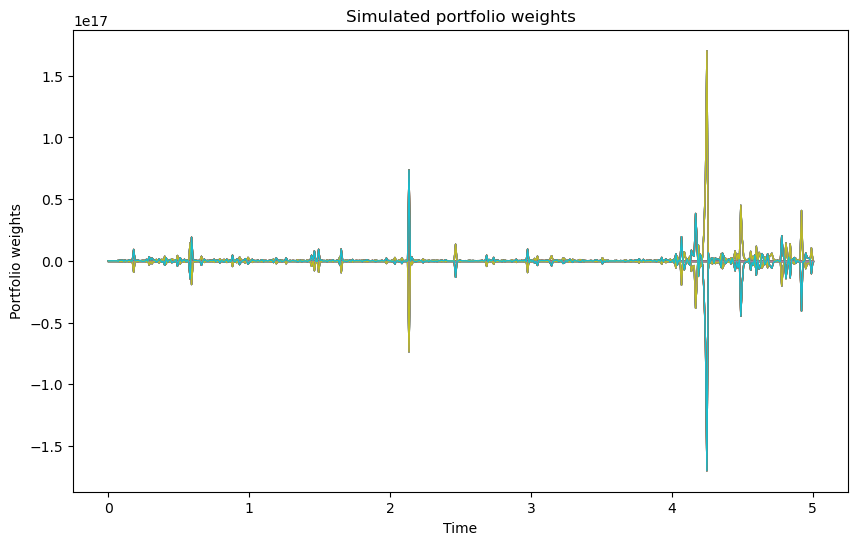

In [12]:
#Define the portfolio weights as arrays of zeros
phi_t_star_path = np.zeros(n_steps)
psi_t_1_star_path=np.zeros(n_steps)
psi_t_2_star_path=np.zeros(n_steps)
theta_B_star_path = np.zeros(n_steps)
theta_Z_star_path=np.zeros(n_steps)
theta_N_star_path=np.zeros(n_steps)
risk_free_path=np.zeros(n_steps)
D=np.zeros(n_steps)

#we begin with an equal distribution in stocks and options
phi_t_star_path[0] = 0.5
psi_t_1_star_path[0]=0.25
psi_t_2_star_path[0]=0.25
theta_B_star_path[0] = 0.5
theta_Z_star_path[0]=0.25
theta_N_star_path[0]=0.25

# Compute k1, k2, and delta
k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa)

for t in range(1, n_steps):
    # Compute optimal portfolio weights for the risk factors
    theta_B_star_path[t], theta_Z_star_path[t], theta_N_star_path[t] = compute_optimal_portfolio_weights(T, t, gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, k1, k2, delta)
    # Transform back to risky asset allocations (stock and derivatives)
    phi_t_star_path[t], psi_t_1_star_path[t], psi_t_2_star_path[t], D[t]= transform_to_risky_assets(theta_B_star_path[t], theta_Z_star_path[t], theta_N_star_path[t], S_paths[t], price_1[t], price_2[t], g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], mu, delta_g_1[t], delta_g_2[t])
    risk_free_path[t]=1-phi_t_star_path[t]-psi_t_1_star_path[t]-psi_t_2_star_path[t]


plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(np.linspace(0, T, n_steps), phi_t_star_path, lw=1)
    plt.plot(np.linspace(0, T, n_steps), psi_t_1_star_path, lw=1)
    plt.plot(np.linspace(0, T, n_steps), psi_t_2_star_path, lw=1)
    plt.plot(np.linspace(0, T, n_steps), risk_free_path, lw=1)
plt.title('Simulated portfolio weights')
plt.xlabel('Time')
plt.ylabel('Portfolio weights')
plt.show()


In [33]:
#We now look at one point in time
#To examine both jump and volatilty risk we look at a strangle consisting of an OTM call and an OTM put, with different strikes. 
#We set both at 5% OTM

phi_vals_r, psi_vals_r, riskfree_vals_r = [], [], []


r_vals=np.linspace(0,0.1,10)


# Loop through each element in loop_array
for r in r_vals:
            
    phi_values=[]
    psi_values=[]
    riskfree_values=[]

    n_steps=10 # Number of steps
    dt = T/n_steps  # Time step
    t = np.linspace(0, T, n_steps+1)

    # Standard Brownian motion for B_t and _t and a jump-pro
    dBt = np.zeros(n_steps+1)
    dZt = np.zeros(n_steps+1)
            
    for i in range(1, n_steps+1):
        dBt[i] = dBt[i-1] + np.sqrt(dt) * np.random.normal()
        dZt[i] = dZt[i-1] + np.sqrt(dt) * np.random.normal()

    #We create a pure jump process N_t
    lambda_j = 0.5  # Rate of the Poisson process (number of jumps per unit time)

    # Initialize the jump process
    dNt = np.zeros(n_steps + 1)
    jump_times = np.cumsum(np.random.exponential(scale=1/lambda_j, size=1000))  # Generate jump times

    # Ensure the jump times do not exceed the total time
    jump_times = jump_times[jump_times <= T]

     # Plot the jump process
    for t in range(1, n_steps + 1):
        dNt[t] = dNt[t-1] + np.sum((jump_times >= (t-1) * dt) & (jump_times < t * dt))
            
    # Initialize arrays for the simulation
    S_paths = np.zeros(n_steps)
    V_paths = np.zeros(n_steps)
    S_paths[0] = S0
    V_paths[0] = V0

    # Initialize arrays for the simulation
    pi_paths = np.zeros(n_steps)
    pi_paths[0] = pi_0

    for t in range(1, n_steps):

        # Stock price process (S_t)
        S_paths[t] = S_paths[t-1] +(r + eta * V + mu * (lambda_n - lambda_q) * V) * S_paths[t-1]*dt + \
                                        np.sqrt(V)* S_paths[t-1] * (dBt[t]-dBt[t-1]) +mu* S_paths[t-1]*((dNt[t]-dNt[t-1]) - lambda_n * V * dt) \

        #Pricing kernel process
        pi_paths[t]=pi_paths[t-1]*(1-(r*dt+eta*np.sqrt(V)*(dBt[t]-dBt[t-1]))+xi*np.sqrt(V)*(dZt[t]-dZt[t-1]))
        #Note that the jump component of the pi process has been removed

    tau = 0.1         # Time to maturity (in years)

     # Additional terms for B and A as per Liu and Pan
    kappa_star = kappa - sigma * (rho*eta + np.sqrt(1-rho)*xi )
    v_bar_star = kappa * nu_bar / kappa_star

    #We create a loop that calculates delta and vega for the straddle for different prices $S_t$

    # Initialize sensitivities
    g_s_1 = np.zeros(n_steps)
    g_v_1 = np.zeros(n_steps)
    price_1=np.zeros(n_steps)
    price_jump_1=np.zeros(n_steps)
    delta_g_1 = np.zeros(n_steps)

    g_s_2 = np.zeros(n_steps)
    g_v_2 = np.zeros(n_steps)
    price_2=np.zeros(n_steps)
    price_jump_2=np.zeros(n_steps)
    delta_g_2 = np.zeros(n_steps)

    g_s_1[0] = 0.5
    g_v_1[0] = 0.3
    g_s_2[0] = -0.5
    g_v_2[0] = 0.3
    delta_g_1[0] = 0
    delta_g_2[0] = 0

    for t in range(1, n_steps):
        # Calculate delta and vega for the call and put using finite differences
        price_1[t], g_s_1[t] = european_option_price_and_delta(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        g_v_1[t] = european_option_vega(S_paths[t], S_paths[t], V, r, tau, option_type="call")
        price_2[t], g_s_2[t] = european_option_price_and_delta(S_paths[t], S_paths[t]*(1-0.01), V, r, tau, option_type="put")
        g_v_2[t] = european_option_vega(S_paths[t], S_paths[t]*(1-0.01), V, r, tau, option_type="put")

        price_jump_1[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t], V, r, tau, option_type="call")
        price_jump_2[t], _ = european_option_price_and_delta(S_paths[t]*(1+mu), S_paths[t]*(1-0.01), V, r, tau, option_type="put")

        # Calculate jump deltas for call and put
        delta_g_1[t] = price_jump_1[t]-price_1[t]
        delta_g_2[t] = price_jump_2[t]-price_2[t]

        # Compute k1, k2, and delta
        k1, k2, delta = compute_k1_k2_delta(gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, kappa) 
        # Compute optimal portfolio weights for the risk factors
        theta_B_star, theta_Z_star, theta_N_star = compute_optimal_portfolio_weights(T, t, gamma, eta, xi, rho, sigma, lambda_n, lambda_q, mu, k1, k2, delta)
        # Transform back to risky asset allocations (stock and derivatives)
        phi, psi_1, psi_2,_ = transform_to_risky_assets(theta_B_star, theta_Z_star, theta_N_star, S_paths[t], price_1[t], price_2[t], g_s_1[t], g_s_2[t], g_v_1[t], g_v_2[t], mu, delta_g_1[t], delta_g_2[t])
        psi=psi_1+psi_2
        risk_free=1-phi-psi_1-psi_2 
            
        phi_values.append(phi)
        psi_values.append(psi)
        riskfree_values.append(risk_free) 

    phi=np.mean(phi_values)
    psi=np.mean(psi_values)
    riskfree=np.mean(riskfree_values)

    phi_vals_r.append(phi)
    psi_vals_r.append(psi)
    riskfree_vals_r.append(riskfree)


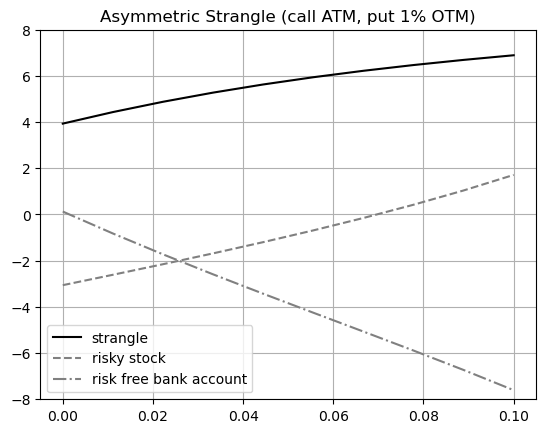

In [34]:
plt.plot(r_vals, psi_vals_r, label='strangle', color='black')
plt.plot(r_vals, phi_vals_r, label='risky stock', linestyle='--', color='gray')
plt.plot(r_vals, riskfree_vals_r, label='risk free bank account', linestyle='-.', color='gray')
plt.title('Asymmetric Strangle (call ATM, put 1% OTM)')
plt.legend()
plt.grid()
plt.ylim(-8, 8)  # Setting y-axis limits
plt.show()

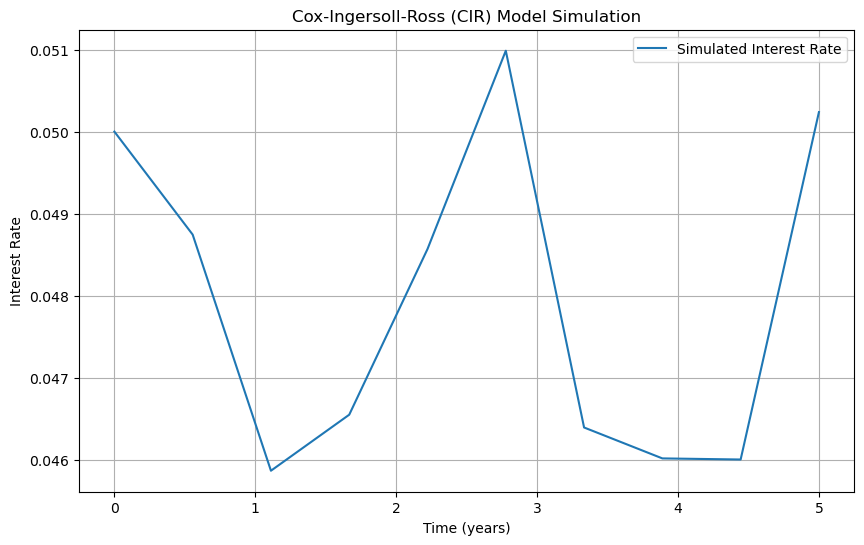

In [15]:
# Parameters for the CIR model
kappa_1 = 0.2  # Speed of mean reversion
theta_1 = 0.05  # Long-term mean level
sigma_1 = 0.02  # Volatility
r0 = 0.05  # Initial interest rate

# Initialize the interest rate array
rates = np.zeros(n_steps)
rates[0] = r0

# Simulate the CIR model
for t in range(1, n_steps):
    dr = kappa_1 * (theta_1 - rates[t-1]) * dt + sigma_1 * np.sqrt(rates[t-1]) * np.random.normal(scale=np.sqrt(dt))
    rates[t] = rates[t-1] + dr

# Plot the simulated interest rate path
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), rates, label='Simulated Interest Rate')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
plt.title('Cox-Ingersoll-Ross (CIR) Model Simulation')
plt.legend()
plt.grid(True)
plt.show()